In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split

import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import os
import re
import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from google.colab import files

import dill


# Download NLTK Data


In [ ]:
nltk.download("stopwords")
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Define Helper Functions


In [ ]:
#Cleans Text
def normalizer(tweet):
    no_urls = re.sub(r"http\S+", " " ,tweet)
    only_letters = re.sub("[^a-zA-Z]", " ",no_urls)
    tokens = nltk.word_tokenize(only_letters)[2 :]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    #lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return filtered_result

#Generate Plots for Model
def plot_graphs(history, metric):
  plt.figure( figsize=(16,12))
  plt.rcParams.update({'font.size': 22})
  plt.plot(history.history[metric])
  #plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

#make a prediction on input text
def predict_on_text(text):
  
  test_text = np.array([text])
  test_df =  pd.DataFrame(test_text, columns = ['text'])

  test_df['normalized_tweet'] = test_df.text.apply(normalizer)
  X = test_df["normalized_tweet"].astype(str)

  df = token.texts_to_sequences(X)

  df = tf.keras.preprocessing.sequence.pad_sequences(df, maxlen=max_length)

  prediction = np.round(model.predict(df)[0][0])

  if prediction:

    return "This is about Sports."

  else:

    return "This is not about Sports."

# compute accuracy
def accuracy(y, y_hat):

  acc = np.mean(y == y_hat)

  print('The accuracy is: ' + str(acc))

#generates confusion matrix
def confusionMatrix(ys,preds):
    
    N = len(ys)
    #Generate empty matrix
    confuse = np.zeros((2,2),dtype=int)
    
    #loop through both arrays
    for i in range(N):
    
      #increase count in entry of each label
      confuse[ys[i],int(preds[i])] = confuse[ys[i],int(preds[i])] + 1
    
    #return as dataframe
    return pd.DataFrame(confuse)

# Read in Data and Clean


In [ ]:
#uploaded = files.upload()

df = pd.read_csv("/content/Reddit Data.csv")

#map data labels to 0 or 1 
df.label = df["label"].replace({"not_sports":0,"sports":1})

#add cleaned data to the DataFrame
df['normalized_tweet'] = df.title.apply(normalizer)

#seperate X and y out as DataFrames
X = df["normalized_tweet"].astype(str)
y = df["label"]

In [ ]:
max_features = 50000 #we set maximum number of words to 5000
max_length = 100 #we set maximum sequence length to 400
embedding_dim = 50 

token = tf.keras.preprocessing.text.Tokenizer(num_words=max_features) 
token.fit_on_texts(X)

vocab_size = len(token.word_index) + 1 

#conver X to a TensorFlow Type and add padding
df = token.texts_to_sequences(X)
df = tf.keras.preprocessing.sequence.pad_sequences(df, maxlen=max_length)


In [ ]:
print(max_length)

100


# Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, y,test_size=0.15,random_state=101)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=1)

# Build Model

In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Embedding(
                                                              input_dim=vocab_size,
                                                              output_dim=embedding_dim,
                                                              input_length=max_length
                                    ),

                                    tf.keras.layers.Flatten(), #flatten layer

                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)

                                    ])

model.compile(optimizer="adam",
              loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = ["accuracy"]
              )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           662800    
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5001      
Total params: 667,801
Trainable params: 667,801
Non-trainable params: 0
_________________________________________________________________


# Train Model

In [ ]:

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="ANN sports",
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 period=12
                                                 )

history=model.fit(np.array(X_train), np.array(y_train), epochs=12, callbacks=[cp_callback]) 

Epoch 1/12
289/289 [==============================] - 3s 11ms/step - loss: 0.5200 - accuracy: 0.9747
Epoch 2/12
289/289 [==============================] - 3s 10ms/step - loss: 0.5200 - accuracy: 0.9746
Epoch 3/12
289/289 [==============================] - 3s 10ms/step - loss: 0.5200 - accuracy: 0.9747
Epoch 4/12
289/289 [==============================] - 3s 10ms/step - loss: 0.5200 - accuracy: 0.9747
Epoch 5/12
289/289 [==============================] - 3s 10ms/step - loss: 0.5200 - accuracy: 0.9747
Epoch 6/12
289/289 [==============================] - 3s 10ms/step - loss: 0.5200 - accuracy: 0.9747
Epoch 7/12
289/289 [==============================] - 3s 10ms/step - loss: 0.5200 - accuracy: 0.9747
Epoch 8/12
289/289 [==============================] - 3s 9ms/step - loss: 0.5200 - accuracy: 0.9747
Epoch 9/12
289/289 [==============================] - 3s 9ms/step - loss: 0.5200 - accuracy: 0.9747
Epoch 10/12
289/289 [==============================] - 3s 9ms/step - loss: 0.5200 - accuracy:

In [ ]:
model.evaluate(X_val,y_val)

33/33 [==============================] - 0s 2ms/step - loss: 0.5705 - accuracy: 0.8667


[0.570514976978302, 0.8667315244674683]

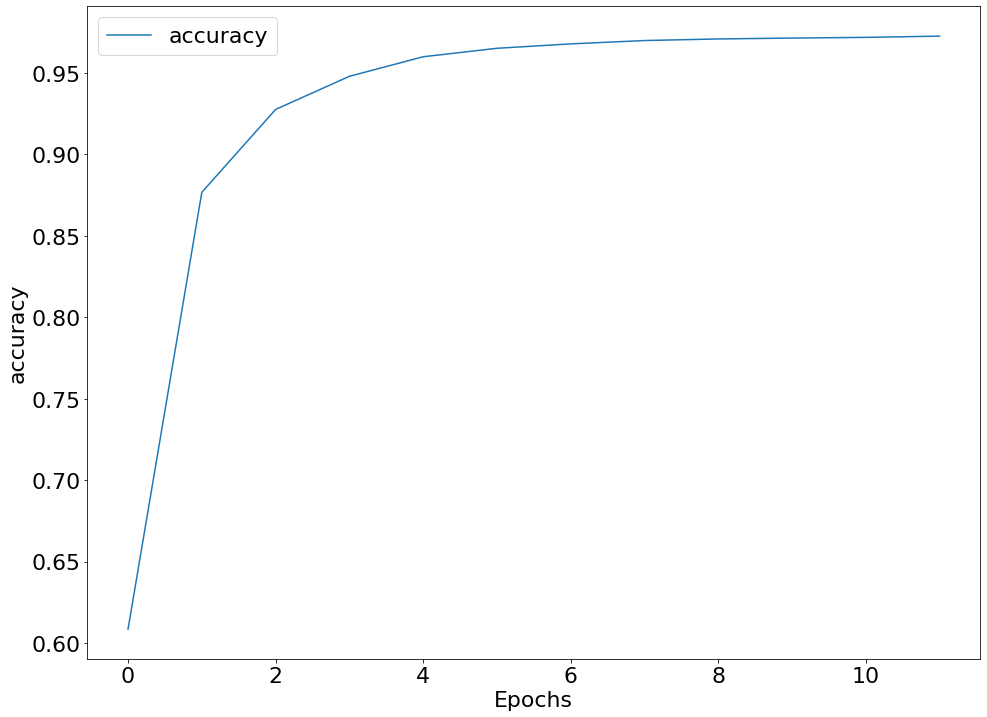

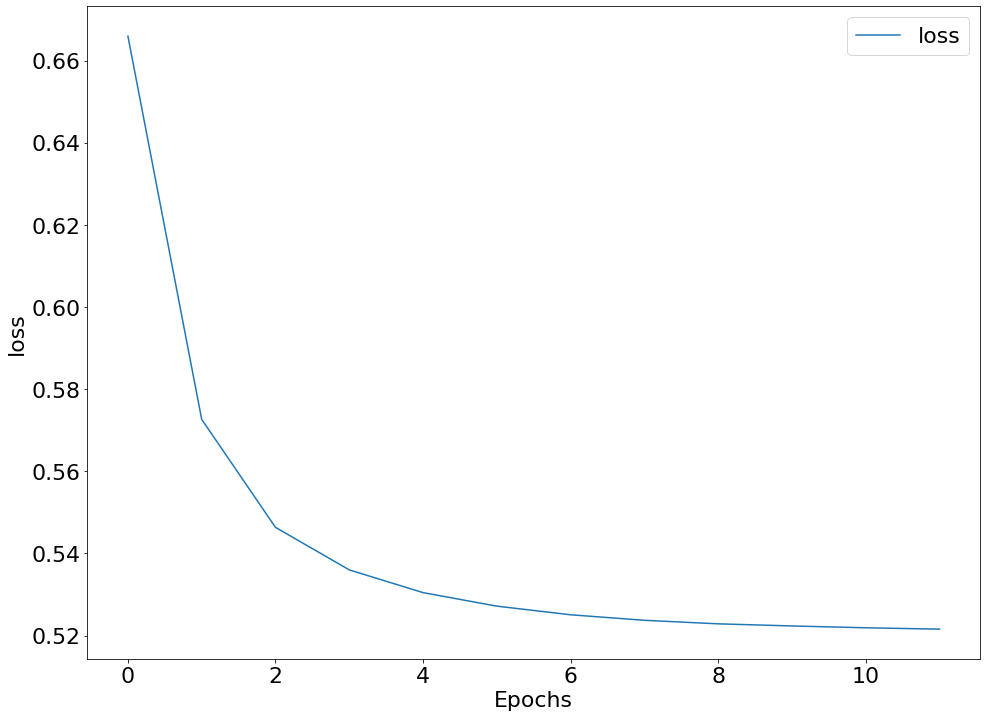

In [ ]:
#plot graphs for training
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Model Testing and Metrics

In [ ]:
#predict on test data
predictions = model.predict(X_test)
predictions = predictions.reshape((1814,))
predictions = np.round(predictions)

#accuracy on test data
accuracy(y_test , predictions)

The accuracy is: 0.8875413450937155


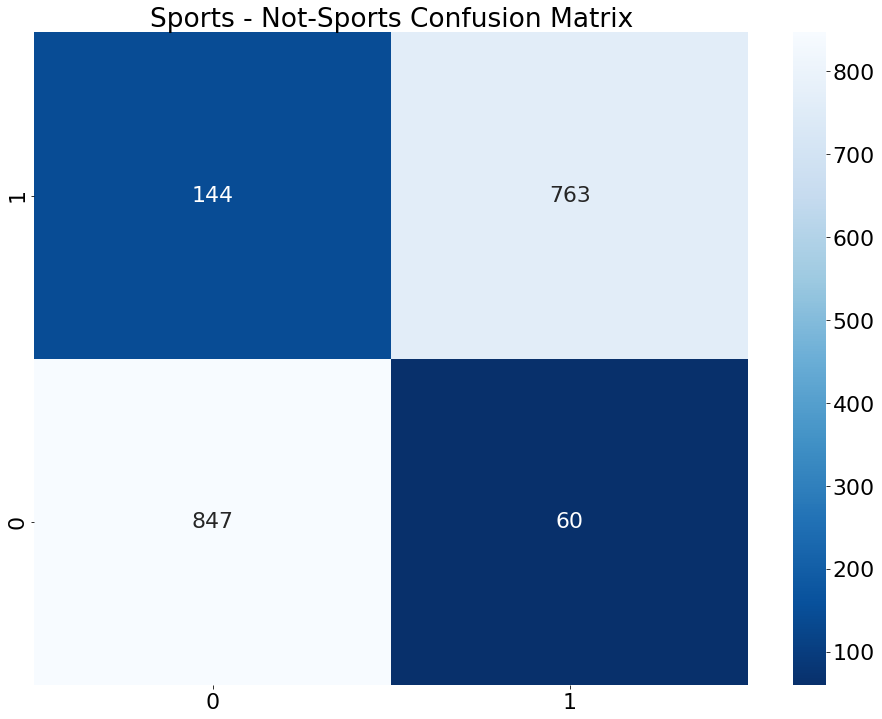

In [ ]:
#Make Confusion Matrix
ys = y_test.to_numpy()
con = confusionMatrix(ys,predictions)
fig1 = plt.figure(figsize=(16,12))
plt.rcParams.update({'font.size': 22})
ax = sns.heatmap(con, annot=True, cmap ='Blues_r' ,fmt='d')
plt.title("Sports - Not-Sports Confusion Matrix")
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.show()

In [ ]:
#Calculate Specificity and Sensitivity 
con_mat = con.to_numpy()
tn = con_mat[0,0]
fn = con_mat[1,0]
fp = con_mat[0,1]
tp = con_mat[1,1]

sensitivity =  tp/(tp+fn)
specificity = tn /(tn+fp)

print('The sensitivity is: ' + str(sensitivity))
print('The specificity is: ' + str(specificity))

The sensitivity is: 0.8412348401323043
The specificity is: 0.9338478500551268


# Predict on New Text

In [ ]:
test_text  = "in football the bears beat the colts 40 to 1"

print(predict_on_text(test_text))

This is about Sports.


In [ ]:
pip install -q pyyaml h5py

In [ ]:
with open("token.pickle", 'wb') as f:

    dill.dump(token,f)
model2 = tf.keras.models.load_model("/content/drive/My Drive/ANN Sports")

predictions = model2.predict(X_test)
predictions = predictions.reshape((1814,))
predictions = np.round(predictions)

accuracy(y_test , predictions)

The accuracy is: 0.8699007717750827


In [ ]:
model.save("ANN Sports")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ANN Sports/assets


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
